# Aimsun Microsimulation SQLite Output Database Analyzer

### Goal of the notebook

This purpose of this Jupyter notebook is to process the database produced by the Aimsun simulations.
***
**Outputs:** 

Comparsion plots:
- compare_link_flow.png
- compare_speed.png
- compare_travel_time.png
- compare_path_flow.png


**Inputs:** 

Aimsun simulation outputs:
- aimsun-outputs.sqlite
- aimsun_outputs.csv

Ground truth data:
- ground.sqlite
- ground.csv


**Dependent scripts:** 
None

 **IMPORTANT:** Run the iPython cell below in order to import the necessary packages.

In [1]:
# Root path of Fremont Dropbox
import os
import sys
# We let this notebook to know where to look for fremontdropbox module
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from fremontdropbox import get_dropbox_location

path_dropbox = get_dropbox_location()
data_folder = os.path.join(path_dropbox, 'Private Structured data collection')
sql_folder = os.path.join(data_folder, 'Aimsun','Outputs')

In [2]:
import numpy as np
import scipy
import matplotlib
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LinearRegression

### SQLite Helper Functions

These functions are wrapper functions for the underlying SQLite commands we use to query data from the SQLite database. The notebook assumes that the Aimsun database file has been placed into the current directory of the notebook.

In [3]:
def create_connection(db_file):
    conn = sqlite3.connect(db_file)
    return conn

def create_df_from_sql_table(conn, table_name):
    query = conn.execute("SELECT * From {}".format(table_name))
    cols = [column[0] for column in query.description]
    results= pd.DataFrame.from_records(data = query.fetchall(), columns = cols)
    return results

def select_all_from_table(conn, table, should_print = True):
    cur = conn.cursor()
    if should_print:
        # Prevents us from accidentally clogging up the notebook with huge print statements
        cur.execute("SELECT * FROM {} LIMIT 10".format(table))
    else:
        cur.execute("SELECT * FROM {}".format(table))
    rows = cur.fetchall()
    if should_print:
        for row in rows:
            print(row)
    return rows

### Other helper functions

### SimulatorInfo Class (SIM_INFO Table)

This class parses information from the ```SIM_INFO``` table in the Aimsun database. This table stores meta information about the simulation in general, including the owner of the file and the version number currently in use.

In [4]:
class SimulatorInfo:
    
    def __init__(self, values):
        self.data_id = values[0]
        self.data_id_name = values[1]
        self.effective_data_id = values[2]
        self.uses_external_id = True if values[4] else False
        self.scenario_date = values[5]
        self.start_time = values[6]
        self.duration = values[7]
        self.rand_seed = values[8]
        self.type = 'Simulated Data' if values[9] == 1 else 'Average'
        self.warm_up_time = values[10]
        self.sim_model = values[11]
        self.aimsun_version = values[12]
        self.num_iters = values[13]
        self.exec_date = values[14]
        self.experiment_id = values[15]
        self.experiment_name = values[16]
        self.scenario_id = values[17]
        self.scenario_name = values[18]
        self.author = values[28]

    def __str__(self):
        delimiter = ","
        return "Data ID: {}{}".format(self.data_id, delimiter) +\
            "Data ID Name: {}{}".format(self.data_id_name, delimiter) +\
            "Start Time: {}{}".format(self.start_time, delimiter) +\
            "Duration: {}{}".format(self.duration, delimiter) +\
            "Type: {}{}".format(self.type, delimiter) +\
            "Simulation Model: {}{}".format(self.sim_model, delimiter) +\
            "Execution Date: {}{}".format(self.exec_date, delimiter) +\
            "Scenarion Name: {}{}".format(self.scenario_name, delimiter) +\
            "Owner: {}".format(self.author)
    
    def __repr__(self):
        return str(self)

The remaining classes for MISECT, MILANE, MIDETEC and MINODE is not used in real implementation and are just kept for reference of the database schema.

### Section Class (MISECT Table)

This class parses information from the ```MISECT``` table in the Aimsun database. This table contains statistical information of the sections for each period. The unit of flow is ```veh/h```, and the unit of speed is ```km/h```.

In [ ]:
class Lane:
    
    def __init__(self, values):
        self.section_id = values[1]
        self.external_id = values[2]
        self.vehicle_type = values[3]
        self.time_interval = values[4]
        self.flow = values[5]
        self.count = values[7]
        self.speed = values[19]
        self.travel_time = values[40]
        
    def __str__(self):
        delimiter = ","
        return "External ID: {}{}".format(self.external_id, delimiter) +\
            "Time Interval: {}{}".format(self.time_interval, delimiter) +\
            "Vehicle Count: {}{}".format(self.vehicle_cnt, delimiter) +\
            "Avg. Flow: {}{}".format(self.flow, delimiter) +\
            "Avg. Speed: {}{}".format(self.speed, delimiter) +\
            "Avg. Travel Time: {}".format(self.travel_time)
    
    def __repr__(self):
        return str(self)

### Lane Class (MILANE Table)

This class parses information from the ```MILANE``` table in the Aimsun database. This table stores microsimulator result statistical information about each lane of the sections for each period.

In [5]:
class Lane:
    
    def __init__(self, values):
        self.replication_id = values[0]
        self.section_id = values[1]
        self.external_id = values[2]
        self.vehicle_type = values[3]
        self.time_interval = values[4]
        self.lane_id = values[5]
        self.vehicle_cnt = values[6]
        self.flow = values[8]
        self.input_vehicle_cnt = values[10]
        self.input_flow = values[12]
        self.density = values[14]
        self.queue_length = values[16]
        self.queue_max_length = values[18]
        self.delay_time = values[20]
        self.queue_waiting_time = values[22]
        self.speed = values[24]
        self.harmonic_speed = values[26]
        self.travel_time = values[28]
        self.stop_time = values[32]
        
    def __str__(self):
        delimiter = ","
        return "External ID: {}{}".format(self.external_id, delimiter) +\
            "Time Interval: {}{}".format(self.time_interval, delimiter) +\
            "Vehicle Count: {}{}".format(self.vehicle_cnt, delimiter) +\
            "Avg. Flow: {}{}".format(self.flow, delimiter) +\
            "Avg. Density: {}{}".format(self.density, delimiter) +\
            "Avg. Queue Length: {}{}".format(self.queue_length, delimiter) +\
            "Avg. Speed: {}{}".format(self.speed, delimiter) +\
            "Avg. Delay Time: {}{}".format(self.delay_time, delimiter) +\
            "Avg. Travel Time: {}".format(self.travel_time)
    
    def __repr__(self):
        return str(self)

### Node Class (MINODE Table)

This class parses information from the ```MINODE``` table in the Aimsun database. This table stores microsimulator result statistical information about each node for each period.

In [6]:
class Node:
    
    def __init__(self, values):
        self.replication_id = values[0]
        self.section_id = values[1]
        self.external_id = values[2]
        self.vehicle_type = values[3]
        self.time_interval = values[4]
        self.approach_delay = values[5]
        self.lost_vehicles = values[7]
        self.missed_turnings = values[9]
    
    def __str__(self):
        delimiter = ","
        return "External ID: {}{}".format(self.external_id, delimiter) +\
            "Time Interval: {}{}".format(self.time_interval, delimiter) +\
            "Avg. Approach Delay: {}{}".format(self.approach_delay, delimiter) +\
            "Lost Vehicles: {}{}".format(self.lost_vehicles, delimiter) +\
            "Missed Turnings: {}".format(self.missed_turnings)
    
    def __repr__(self):
        return str(self)

### Detector Class (MIDETEC Table)

This class parses information from the ```MIDETEC``` table in the Aimsun database. This table stores microsimulator result statistical information collected by a detector in a road section.

In [7]:
class Detector:
    
    def __init__(self, values):
        self.replication_id = values[0]
        self.section_id = values[1]
        self.external_id = values[2]
        self.vehicle_type = values[3]
        self.time_interval = values[4]
        self.vehicle_count = values[5]
        self.flow = values[7]
        self.speed = values[9]
        self.occupancy = values[11]
        self.density = values[13]
        self.headway = values[15]
    
    def __str__(self):
        delimiter = ","
        return "External ID: {}{}".format(self.external_id, delimiter) +\
            "Time Interval: {}{}".format(self.time_interval, delimiter) +\
            "Vehicle Count: {}{}".format(self.vehicle_count, delimiter) +\
            "Flow: {}{}".format(self.flow, delimeter) +\
            "Avg. Speed: {}{}".format(self.speed, delimiter) +\
            "Avg. Occupancy: {}{}".format(self.occupancy, delimiter) +\
            "Avg. Density: {}{}".format(self.density, delimiter) +\
            "Avg. Headway: {}".format(self.headway)
    
    def __repr__(self):
        return str(self)

### Main AimsunAnalyzer Class

To be implemented. The skeleton code has been given below.

Tables MINODE, MILANE and MIDETEC are converted into dataframes and stored before further analysis.

In [9]:
class AimsunAnalyzer:
    
    def __init__(self, simulation_file, simulation_filetype, ground_truth_file = None, ground_truth_filetype = None):
        """
        Initializes the Aimsun analyzer.
        
        @param simulation_file:          The file path of the source file of Aimsun macro/microsimulation outputs.
        @param simulation_filetype:      The type of the src_simulation file (can be .csv or .sqlite).
        @param ground_truth_file:        The file path of the source file of Aimsun macro/microsimulation outputs.
        @param ground_truth_filetype:    The type of the src_simulation file (can be .csv or .sqlite).
        """
        self.database = simulation_file
        self.conn = create_connection(self.database)
        print("=====Connection Established.=====")
        
        self.model_info = SimulatorInfo(select_all_from_table(self.conn, "SIM_INFO", should_print = False)[0])
        self.start_hour = int(self.model_info.start_time)//3600
        self.start_min = int((self.model_info.start_time) - self.start_hour * 3600)%60
        print("Simulation starts at "+str(self.start_hour)+"h"+str(self.start_min)+"min")
        print("=====Model Information Loaded.=====")
        
        self.sections = create_df_from_sql_table(self.conn, "MISECT")
        self.vehTrajectroy = create_df_from_sql_table(self.conn, "MIVEHTRAJECTORY")
        self.vehSectTrajectory = create_df_from_sql_table(self.conn, "MIVEHSECTTRAJECTORY")
#         self.nodes = create_df_from_sql_table(self.conn, "MINODE")
#         self.lanes = create_df_from_sql_table(self.conn, "MILANE")
#         self.detectors = create_df_from_sql_table(self.conn, "MIDETEC")

        print("=====Simulation Data Loaded.=====")
        
        self.ground_truth_file = ground_truth_file
        self.ground_truth_filetype = ground_truth_filetype
    
    # convert time in string format to an int from 0 to 23, i.e. 14:45 -> 3
    def convert_time_str_to_int(self, time_interval):
        dt = datetime.datetime.strptime(time_interval, '%H:%M')
        time = (dt.hour-self.start_hour)*4 + (dt.minute-self.start_min)//15
        return int(time)
    
    def get_link_flow(self, road_id, time_interval):
        """
        Returns the link flow for a road_id at a certain time interval.

        @param road_id:         The external ID of the road in Aimsun in string format, i.e. "1242".
        @param time_interval:   The starting time interval, represented as a string, i.e. "0:45".

        @return:                The link flow on the road with road_id within the time interval.
        """
        time = self.convert_time_str_to_int(time_interval)
        flow = self.sections[(self.sections["eid"]==road_id) & (self.sections["ent"]==time)]["flow"].sum()
        return flow

    def get_speed(self, road_id, time_interval):
        """
        Returns the speed for a road_id at a certain time interval.

        @param road_id:         The external ID of the road in Aimsun in string format, i.e. "1242".
        @param time_interval:   The starting time interval, represented as a string, i.e. "0:45".

        @return:                The speed on the road with road_id within the time interval.
        """
        time = self.convert_time_str_to_int(time_interval)
        speed = self.sections[(self.sections["eid"]==road_id) & (self.sections["ent"]==time)]["speed"].values[0]
        if speed==-1:
            return 0
        return speed

    def get_travel_time(self, o_id, d_id, time_interval):
        """
        Returns the time interval to get from an origin ID to a destination ID, starting at a certain time interval.

        @param o_id:            The external ID of the origin centroid.
        @param d_id:            The external ID of the destination centroid.
        @param time_interval:   The starting time interval.

        @return:                The travel time within the time interval from o_id to d_id
        """
        pass

    def get_path_flow(self, o_id, d_id, time_interval):
        """
        Returns the path flow from an origin ID to a destination ID, starting at a certain time interval.

        @param o_id:            The external ID of the origin centroid.
        @param d_id:            The external ID of the destination centroid.
        @param time_interval:   The starting time interval.

        @return:                The path flow within the time interval between start_time and end_time and
                                from o_id to d_id formatted as [(road_ids_1, flow_1), (road_ids_2, flow_2), ...]
        """
        pass

    def compare_flows(self, road_ids, time_interval, src_simulation, src_type_simuatlion):
        """
        Returns a matplotlib plot with comparison information on the flows for the given road IDs at the
        specified time intervals.

        @param road_ids:              A list of the road IDs to be compared.
        @param time_interval:         A list of the corresponding time intervals for the road IDs.

        @return:                      A comparison plot in Matplotlib for the link flows.
        @return:                      The list of link flows within the time interval between start_time
                                      and end_time on roads with road_ids.
        """
        if self.ground_truth_data is None:
            print("Error: No ground truth has been passed in.")

    def compare_speed(self, road_ids, time_intervals, src_simulation, src_type_simulation):
        """
        Returns a matplotlib plot with comparison information on the avg. speeds for the given road IDs at the
        specified time intervals.

        @param road_ids:              A list of the road IDs to be compared.
        @param time_intervals:        A list of the corresponding time intervals for the road IDs.

        @return:                      A comparison plot in Matplotlib for the average speeds.
        @return:                      The list of speed within the time interval between start_time and
                                      end_time on roads with road_ids.
        """
        if self.ground_truth_data is None:
            print("Error: No ground truth has been passed in.")

    def compare_travel_time(self, od_ids, time_intervals):
        """
        Returns a matplotlib plot with comparison information on the travel times for the given origin/destination
        centroid IDs at the specified time intervals.

        @param od_ids:                A list of tuples of (o_id, d_id)
        @param time_interval:         A list of the corresponding time intervals for the road IDs.

        @return:                      A comparison plot in Matplotlib for the average travel times.
        @return:                      The list of travel time within the time interval between start_time
                                      and end_time and from o_ids to d_ids.
        """
        if self.ground_truth_data is None:
            print("Error: No ground truth has been passed in.")

    def compare_path_flow(self, od_ids, time_intervals):
        """
        Returns a matplotlib plot with comparison information on the path flows for the given origin/destination
        centroid IDs at the specified time intervals.

        @param od_ids:                A list of tuples of (o_id, d_id)
        @param time_interval:         A list of the corresponding time intervals for the road IDs.

        @return:                      A comparison plot in Matplotlib for the average path flows.
        @return:                      The list path flow within the time interval between start_time
                                      and end_time and from o_ids to d_ids.
        """
        if self.ground_truth_data is None:
            print("Error: No ground truth has been passed in.")

## Main Code

This section contains the code that should be run in order to generate results in this notebook. Below is the necessary starter code that connects to the database and outputs the current simulator info:

In [10]:
database = os.path.join(sql_folder, "2019_latest_0406.sqlite")
analyzer = AimsunAnalyzer(database, "sqlite")

=====Connection Established.=====
Simulation starts at 14h0min
=====Model Information Loaded.=====
=====Simulation Data Loaded.=====


In [11]:
analyzer.get_link_flow("35500","14:45")

96.0

In [13]:
analyzer.get_speed("35500", "14:45")

55.42537382163743

### Skeleton codes begin here, will be written as functions later

In [14]:
# load the id correspondence files
id_corr_folder = os.path.join(data_folder,"Data processing","Temporary exports to be copied to processed data","Network","Infrastructure")
id_city_file_name = "detectors_to_road_segments_2019.csv"
id_pems_file_name = "detectors_to_road_segments_pems.csv"

detector_id_to_road_eid_city = pd.read_csv(os.path.join(id_corr_folder,id_city_file_name)).astype(int)
detector_id_to_road_eid_pems = pd.read_csv(os.path.join(id_corr_folder,id_pems_file_name)).astype(int)

display(detector_id_to_road_eid_city.head(5))

,Detector_Id,Road_Id
0,201901,30044
1,201902,35160
2,201903,8549
3,201904,8548
4,201905,35233


### Compare flow

In [15]:
flow_ground_folder = os.path.join(data_folder,"Data processing","Temporary exports to be copied to processed data","Demand","Flow_speed")
flow_ground_file_name = "flow_processed_2019.csv"
flow_ground = pd.read_csv(os.path.join(flow_ground_folder, flow_ground_file_name)).fillna(242)
flow_ground["Road_Id"] = flow_ground["Road_Id"].astype(int).astype(str)
flow_ground["Detector_Id"] = flow_ground["Detector_Id"].astype(int).astype(str)
display(flow_ground.head(2))

,Name,Direction,Detector_Id,Road_Id,Year,0:0,0:15,0:30,0:45,1:0,...,21:30,21:45,22:0,22:15,22:30,22:45,23:0,23:15,23:30,23:45
0,AUTO MALL PKWY BT FREMONT BLVD AND I-680 EB.csv,EB,201901,30044,2019,51.666667,50.666667,44.0,45.666667,31.666667,...,223.333333,160.333333,141.333333,103.666667,108.000000,70.666667,68.333333,92.000000,84.333333,60.666667
1,AUTO MALL PKWY BT FREMONT BLVD AND I-680 WB.csv,WB,201902,35160,2019,30.000000,21.000000,21.0,24.333333,22.666667,...,132.000000,120.333333,92.333333,91.333333,70.666667,55.333333,41.000000,48.333333,35.333333,39.333333


In [16]:
time_interval = flow_ground.loc[:,"14:0":"19:45"].columns
time_interval

Index(['14:0', '14:15', '14:30', '14:45', '15:0', '15:15', '15:30', '15:45',
       '16:0', '16:15', '16:30', '16:45', '17:0', '17:15', '17:30', '17:45',
       '18:0', '18:15', '18:30', '18:45', '19:0', '19:15', '19:30', '19:45'],
      dtype='object')

In [25]:
# compare ground data with simulation data
# ground flow unit: # vehicles per 15min
# the unit of the simluation flow is # of vechicles per hour and have to be converted to per 15 min
for time in time_interval:
    flow_ground["sim_flow_"+str(time)]=flow_ground.apply(lambda row : (analyzer.get_link_flow(row['Road_Id'], time))/4, axis=1)


R^2:  0.5986999476711263
slope [[1.10087279]]
intercept [-31.02479164]


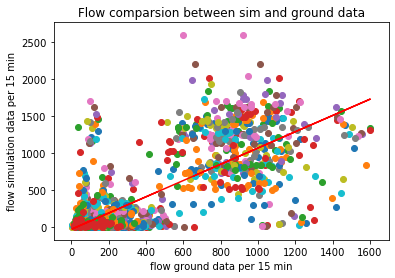

,Name,Direction,Detector_Id,Road_Id,Year,0:0,0:15,0:30,0:45,1:0,...,sim_flow_17:30,sim_flow_17:45,sim_flow_18:0,sim_flow_18:15,sim_flow_18:30,sim_flow_18:45,sim_flow_19:0,sim_flow_19:15,sim_flow_19:30,sim_flow_19:45
0,AUTO MALL PKWY BT FREMONT BLVD AND I-680 EB.csv,EB,201901,30044,2019,51.666667,50.666667,44.000000,45.666667,31.666667,...,378.0,454.0,226.0,0.0,0.0,14.0,16.0,32.0,52.0,10.0
1,AUTO MALL PKWY BT FREMONT BLVD AND I-680 WB.csv,WB,201902,35160,2019,30.000000,21.000000,21.000000,24.333333,22.666667,...,600.0,670.0,614.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,DURHAM RD BT I-680 AND MISSION BLVD EB.csv,EB,201903,8549,2019,4.000000,2.666667,2.666667,1.666667,1.666667,...,6.0,20.0,6.0,10.0,4.0,0.0,2.0,0.0,0.0,0.0


In [26]:
# plot flow biplot for all time intervals
fig = plt.figure()
ground_data_all = pd.Series()
sim_data_all = pd.Series()
regressor = LinearRegression()  

for time in time_interval:
    to_show = flow_ground["sim_flow_"+str(time)]!=0
    plt.scatter(flow_ground[to_show][time], flow_ground[to_show]["sim_flow_"+str(time)])
    sim_data_all = sim_data_all.append(flow_ground[to_show]["sim_flow_"+str(time)], ignore_index=True)
    ground_data_all = ground_data_all.append(flow_ground[to_show][time], ignore_index=True)
    
plt.xlabel("flow ground data per 15 min")
plt.ylabel("flow simulation data per 15 min")
plt.title("Flow comparsion between sim and ground data")

# fit a linear regression
X = ground_data_all.values.reshape(-1,1)
Y_true = sim_data_all.values.reshape(-1,1)

regressor.fit(X, Y_true)
sim_pred = regressor.predict(X)

plt.plot(X, sim_pred, '-r')
print("R^2: ", regressor.score(X, Y_true))
print("slope", regressor.coef_)
print("intercept", regressor.intercept_)

plt.show()

display(flow_ground.head(3))

### Compare speed

Get the mean speed from the raw file, and add to the processed speed.

if the measured time for ground data is not within the simulation time 2pm-8pm, treat as measured at 2pm.

In [79]:
speed_ground_folder = os.path.join(data_folder,"Data processing","Temporary exports to be copied to processed data","Demand","Flow_speed")
speed_ground_file_name = "2015_Speed_Processed_Percent.csv"
speed_raw_folder = os.path.join(data_folder, "Data processing", "Raw", "Demand", "Flow_speed", "Kimley Horn Data")

speed_ground = pd.read_csv(os.path.join(speed_ground_folder, speed_ground_file_name)).fillna(0)
speed_ground["Road_Id"] = speed_ground["Road_Id"].astype(int).astype(str)
speed_ground["Detector_Id"] = speed_ground["Detector_Id"].astype(int).astype(str)
speed_ground["StartTime"] = speed_ground["StartTime"].str[:-3]
speed_ground["EndTime"] = speed_ground["EndTime"].str[:-3]
speed_ground["Interval"] = speed_ground.apply(lambda row: analyzer.convert_time_str_to_int(row["StartTime"]), axis=1)
# if the measured time for ground data is not within the simulation time 2pm-8pm, label the interval as 0.
out_range = (speed_ground["Interval"]<0) | (speed_ground["Interval"]>=24)
speed_ground["SimTime"] = speed_ground["StartTime"]
speed_ground.at[(speed_ground["Interval"]<0) | (speed_ground["Interval"]>=24), 'SimTime'] = "14:00"

for f in os.listdir(speed_raw_folder):
    if('xls' in f):
        file = pd.read_excel(os.path.join(speed_raw_folder, f), sheet_name = "Sheet1")
        mean_speed = file.iloc[28,7]
        speed_ground.at[speed_ground['Name']==f,'Mean_speed (mph)']=mean_speed

display(speed_ground.tail(4))

,Unnamed: 0,Name,Detector_Id,Road_Id,StartTime,EndTime,Direction,Speed limit,50,49,...,6,5,4,3,2,1,0,Interval,SimTime,Mean_speed (mph)
26,EB_Cum,139 - Washington Boulevard - Driscoll Road to ...,201527,7302,10:35,11:15,EB,40 mph,0,0,...,1.0,1.0,1,1,1,1,1,-14,14:00,38.8
27,WB_Cum,139 - Washington Boulevard - Driscoll Road to ...,201528,3342,10:35,11:15,WB,40 mph,0,0,...,1.0,1.0,1,1,1,1,1,-14,14:00,38.8
28,EB_Cum,61 - South Grimmer Blvd - Osgood Rd to Fremont...,201503,35465,14:15,15:00,EB,40 mph,0,0,...,1.0,1.0,1,1,1,1,1,1,14:15,41.6
29,WB_Cum,61 - South Grimmer Blvd - Osgood Rd to Fremont...,201504,35473,14:15,15:00,WB,40 mph,0,0,...,1.0,1.0,1,1,1,1,1,1,14:15,41.6


In [81]:
# ground speed unit: mph
# simulation speed is in km/h, need to be converted to mph

speed_ground["sim_speed"]=speed_ground.apply(lambda row : (analyzer.get_speed(row['Road_Id'], row['SimTime']))/1.6 , axis=1)
speed_ground

# speed_ground["sim_speed"]=speed_ground.apply(lambda row : (analyzer.get_speed(row['Road_Id'], row['SimTime']))/1.6 if (row['Interval_start']>=0 and row['Interval_start']<24) else -1, axis=1)
# speed_ground

,Unnamed: 0,Name,Detector_Id,Road_Id,StartTime,EndTime,Direction,Speed limit,50,49,...,5,4,3,2,1,0,Interval,SimTime,Mean_speed (mph),sim_speed
0,EB_Cum,60 - Grimmer Blvd - Paseo Padre Pkwy to Osgood...,201505,30172,10:30,11:20,EB,40 mph,0,0,...,1.000000,1,1,1,1,1,-14,14:00,38.9,27.705717
1,WB_Cum,60 - Grimmer Blvd - Paseo Padre Pkwy to Osgood...,201506,30203,10:30,11:20,WB,40 mph,0,0,...,1.000000,1,1,1,1,1,-14,14:00,38.9,32.658439
2,NB_Cum,83 - Mission Blvd - Pine St to Durham Rd.xls,201511,7389,12:15,12:45,NB,45 mph,0,0,...,0.990476,1,1,1,1,1,-7,14:00,44.4,48.930039
3,SB_Cum,83 - Mission Blvd - Pine St to Durham Rd.xls,201512,7386,12:15,12:45,SB,45 mph,0,0,...,1.000000,1,1,1,1,1,-7,14:00,44.4,48.616919
4,NB_Cum,135 - Warren Avenue - Curtner Road to Warm Spr...,201525,7595,9:30,11:15,NB,35 mph,0,0,...,1.000000,1,1,1,1,1,-18,14:00,35.4,30.329060
5,SB_Cum,135 - Warren Avenue - Curtner Road to Warm Spr...,201526,7115,9:30,11:15,SB,35 mph,0,0,...,1.000000,1,1,1,1,1,-18,14:00,35.4,0.000000
6,EB_Cum,44 - Durham Rd - I-680 to Mission Blvd.xls,201501,7515,10:50,11:50,EB,40 mph,0,0,...,1.000000,1,1,1,1,1,-13,14:00,40.2,29.060618
7,WB_Cum,44 - Durham Rd - I-680 to Mission Blvd.xls,201502,2810,10:50,11:50,WB,40 mph,0,0,...,1.000000,1,1,1,1,1,-13,14:00,40.2,33.077765
8,NB_Cum,82 - Mission Blvd - St Joseph Terr to Pine St.xls,201513,7432,10:45,12:00,NB,35 mph,0,0,...,1.000000,1,1,1,1,1,-13,14:00,31.8,42.283551
9,SB_Cum,82 - Mission Blvd - St Joseph Terr to Pine St.xls,201514,7433,10:45,12:00,SB,35 mph,0,0,...,1.000000,1,1,1,1,1,-13,14:00,31.8,33.666115


R^2:  0.17849594577334782
slope [[0.726324]]
intercept [8.62264321]


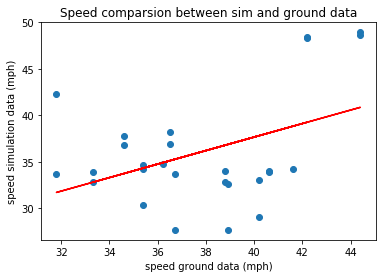

,Unnamed: 0,Name,Detector_Id,Road_Id,StartTime,EndTime,Direction,Speed limit,50,49,...,5,4,3,2,1,0,Interval,SimTime,Mean_speed (mph),sim_speed
0,EB_Cum,60 - Grimmer Blvd - Paseo Padre Pkwy to Osgood...,201505,30172,10:30,11:20,EB,40 mph,0,0,...,1.000000,1,1,1,1,1,-14,14:00,38.9,27.705717
1,WB_Cum,60 - Grimmer Blvd - Paseo Padre Pkwy to Osgood...,201506,30203,10:30,11:20,WB,40 mph,0,0,...,1.000000,1,1,1,1,1,-14,14:00,38.9,32.658439
2,NB_Cum,83 - Mission Blvd - Pine St to Durham Rd.xls,201511,7389,12:15,12:45,NB,45 mph,0,0,...,0.990476,1,1,1,1,1,-7,14:00,44.4,48.930039


In [83]:
# plot speed biplot for all time intervals
fig = plt.figure()
ground_data_all = pd.Series()
sim_data_all = pd.Series()
regressor = LinearRegression()  

to_show = speed_ground["sim_speed"]!=0
plt.scatter(speed_ground[to_show]["Mean_speed (mph)"], speed_ground[to_show]["sim_speed"])
plt.xlabel("speed ground data (mph)")
plt.ylabel("speed simulation data (mph)")
plt.title("Speed comparsion between sim and ground data")

# fit a linear regression
X = speed_ground[to_show]["Mean_speed (mph)"].values.reshape(-1,1)
Y_true = speed_ground[to_show]["sim_speed"].values.reshape(-1,1)

regressor.fit(X, Y_true)
sim_pred = regressor.predict(X)

plt.plot(X, sim_pred, '-r')
print("R^2: ", regressor.score(X, Y_true))
print("slope", regressor.coef_)
print("intercept", regressor.intercept_)

plt.show()

display(speed_ground.head(3))

### Compare travel time

### Ignore this part --- for testing

In [18]:
database = os.path.join(sql_folder, "2019_latest_0406.sqlite")
conn = create_connection(database)
tb_name = "MIVEHTRAJECTORY"
query = conn.execute("SELECT * From {}".format(tb_name))
cols = [column[0] for column in query.description]
results= pd.DataFrame.from_records(data = query.fetchall(), columns = cols)
# nodes = pd.read_sql_table("MINODE", conn)
results

,did,oid,sid,origin,destination,entranceSection,generationTime,entranceTime,exitTime,expectedTravelTime,delayTime,travelledDistance,pathType
0,27989,1,63069,67992,68004,0,1.01296,50401.0,50641.5,0.0,0.510548,8640.38,None


[[ 18.        ]
 [ 96.33333333]
 [103.66666667]
 [ 70.        ]
 [ 86.        ]
 [ 35.33333333]
 [ 96.66666667]
 [ 33.33333333]
 [207.66666667]
 [ 95.        ]
 [ 60.66666667]
 [ 73.        ]]


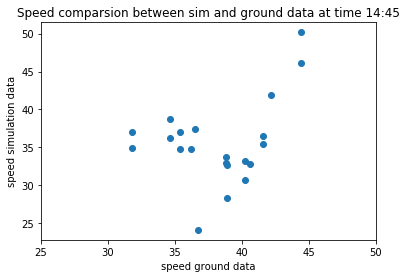

,Unnamed: 0,Name,Detector_Id,Road_Id,StartTime,EndTime,Direction,Speed limit,50,49,...,7,6,5,4,3,2,1,0,Mean_speed (mph),sim_speed_14:45
0,EB_Cum,60 - Grimmer Blvd - Paseo Padre Pkwy to Osgood...,201505,30172,10:30:00,11:20:00,EB,40 mph,0,0,...,1.000000,1.000000,1.000000,1,1,1,1,1,38.9,28.282951
1,WB_Cum,60 - Grimmer Blvd - Paseo Padre Pkwy to Osgood...,201506,30203,10:30:00,11:20:00,WB,40 mph,0,0,...,1.000000,1.000000,1.000000,1,1,1,1,1,38.9,32.612342
2,NB_Cum,83 - Mission Blvd - Pine St to Durham Rd.xls,201511,7389,12:15:00,12:45:00,NB,45 mph,0,0,...,0.942857,0.942857,0.990476,1,1,1,1,1,44.4,46.063581
3,SB_Cum,83 - Mission Blvd - Pine St to Durham Rd.xls,201512,7386,12:15:00,12:45:00,SB,45 mph,0,0,...,0.927273,0.963636,1.000000,1,1,1,1,1,44.4,50.169407
4,NB_Cum,135 - Warren Avenue - Curtner Road to Warm Spr...,201525,7595,9:30:00,11:15:00,NB,35 mph,0,0,...,1.000000,1.000000,1.000000,1,1,1,1,1,35.4,0.000000
5,SB_Cum,135 - Warren Avenue - Curtner Road to Warm Spr...,201526,7115,9:30:00,11:15:00,SB,35 mph,0,0,...,1.000000,1.000000,1.000000,1,1,1,1,1,35.4,0.000000
6,EB_Cum,44 - Durham Rd - I-680 to Mission Blvd.xls,201501,7515,10:50:00,11:50:00,EB,40 mph,0,0,...,1.000000,1.000000,1.000000,1,1,1,1,1,40.2,30.632012
7,WB_Cum,44 - Durham Rd - I-680 to Mission Blvd.xls,201502,2810,10:50:00,11:50:00,WB,40 mph,0,0,...,1.000000,1.000000,1.000000,1,1,1,1,1,40.2,33.170821
8,NB_Cum,82 - Mission Blvd - St Joseph Terr to Pine St.xls,201513,7432,10:45:00,12:00:00,NB,35 mph,0,0,...,1.000000,1.000000,1.000000,1,1,1,1,1,31.8,34.905906
9,SB_Cum,82 - Mission Blvd - St Joseph Terr to Pine St.xls,201514,7433,10:45:00,12:00:00,SB,35 mph,0,0,...,1.000000,1.000000,1.000000,1,1,1,1,1,31.8,37.009598


In [41]:
# ignore this cell

# for example, we want to get the speed comparison at 14:45 
# Potential problem: ground speed data is only available for limited time intervals
# ground speed unit: mph

time_interval = ["14:45"]
for time in time_interval:
    # simulation speed is in km/h, need to be converted to mph
    speed_ground["sim_speed_"+str(time)]=speed_ground.apply(lambda row : (analyzer.get_speed(row['Road_Id'], time))/1.6, axis=1)

# plot biplot for all time intervals
fig = plt.figure()

for time in time_interval:
    to_show = speed_ground["sim_speed_"+str(time)]!= 0
    plt.scatter(speed_ground[to_show]["Mean_speed (mph)"], speed_ground[to_show]["sim_speed_"+str(time)])
    plt.xlabel("speed ground data")
    plt.ylabel("speed simulation data")
    plt.title("Speed comparsion between sim and ground data at time "+time)
    plt.xlim([25, 50])
    plt.show()

display(speed_ground)